In [1]:
import os #OS commands
import numpy as np
import json
import pandas as pd
import geopandas as gp
import pylab as pl
%pylab inline
import zipfile
import statsmodels.formula.api as smf
import geopandas as gpd
import datetime



Populating the interactive namespace from numpy and matplotlib


In [2]:
#unzip REData/Neighborhood.zip 

os.listdir('data/Neighborhood')

['ForeclosuresPer10Khomes_Neighborhood.csv',
 'InventoryMeasure_Neighborhood_Public.csv',
 'InventoryMeasure_SSA_Neighborhood_Public.csv',
 'MonthlyTurnover_Neighborhood.csv',
 'Neighborhood_Listings_PriceCut_SeasAdj_AllHomes.csv',
 'Neighborhood_Listings_PriceCut_SeasAdj_Condominum.csv',
 'Neighborhood_Listings_PriceCut_SeasAdj_SingleFamilyResidence.csv',
 'Neighborhood_MedianListingPricePerSqft_1Bedroom.csv',
 'Neighborhood_MedianListingPricePerSqft_2Bedroom.csv',
 'Neighborhood_MedianListingPricePerSqft_3Bedroom.csv',
 'Neighborhood_MedianListingPricePerSqft_4Bedroom.csv',
 'Neighborhood_MedianListingPricePerSqft_5BedroomOrMore.csv',
 'Neighborhood_MedianListingPricePerSqft_AllHomes.csv',
 'Neighborhood_MedianListingPricePerSqft_BottomTier.csv',
 'Neighborhood_MedianListingPricePerSqft_CondoCoop.csv',
 'Neighborhood_MedianListingPricePerSqft_DuplexTriplex.csv',
 'Neighborhood_MedianListingPricePerSqft_MiddleTier.csv',
 'Neighborhood_MedianListingPricePerSqft_Sfr.csv',
 'Neighborhood

In [3]:
# sale price per square ft
featureOne =  'data/Neighborhood/Neighborhood_MedianListingPricePerSqft_AllHomes.csv' # 45 complete rows
#featureOne =  'data/Neighborhood/Neighborhood_MedianListingPricePerSqft_2Bedroom.csv'
#featureOne =  'data/Neighborhood/Sale_Prices_Neighborhood.csv'
#featureOne =  'data/Neighborhood/Neighborhood_MedianListingPrice_2Bedroom.csv'
#featureOne = 'data/Neighborhood/Neighborhood_MedianListingPricePerSqft_MiddleTier.csv'
#featureOne = 'data/Neighborhood/Neighborhood_MedianListingPrice_MiddleTier.csv'
#featureOne = 'data/Neighborhood/Neighborhood_MedianListingPrice_AllHomes.csv' #54 complete rows
#featureOne = 'data/Neighborhood/Neighborhood_Listings_PriceCut_SeasAdj_AllHomes.csv'

featureTwo = 'data/Neighborhood/Neighborhood_MedianRentalPricePerSqft_AllHomes.csv'
#featureTwo= 'data/Neighborhood/Neighborhood_MedianRentalPrice_AllHomes.csv'
#featureTwo = 'data/Neighborhood/Neighborhood_MedianValuePerSqft_AllHomes.csv'

# % decline in home value
featureThree =  'data/Neighborhood/Neighborhood_PctOfHomesDecreasingInValues_AllHomes.csv'

# % increase in home value
featureFour = 'data/Neighborhood/Neighborhood_PctOfHomesIncreasingInValues_AllHomes.csv'

#featureFive = 'data/Neighborhood/ForeclosuresPer10Khomes_Neighborhood.csv' #not good
featureFive = 'data/Neighborhood/Sale_Counts_BottomTier_Neighborhood.csv'

#sales count top tier
featureSix = 'data/Neighborhood/Sale_Counts_TopTier_Neighborhood.csv'

#inventory
featureSeven = 'data/Neighborhood/InventoryMeasure_Neighborhood_Public.csv'
#featureSeven = 'data/Neighborhood/'InventoryMeasure_SSA_Neighborhood_Public./csv'


In [4]:
def filterThis(thisDF, column, filterThis):
    thisDF = thisDF.loc[thisDF[column]==filterThis]
    return thisDF

def filterbyID(thisDF):
    thisDF = thisDF.loc[thisDF.loc[:,'RegionID'].isin(NYregions.keys())]
    return thisDF

def makeDict(IDcolumn, nameColumn):
    regions ={IDcolumn.iloc[i]:nameColumn.iloc[i] for i in range(len(IDcolumn))}
    return regions

#make the region ID from the region name
def makeRegID(thisDF):
   # thisDF['RegionID']=0
    thisDF.insert(loc=0, column='RegionID', value=0)
    #thisDF.RegionID = thisDF.RegionID.astype(int)
    rkeys = NYregions.keys()
    #cycle through all rows in data frame
    for l in range(thisDF.shape[0]):
        #check that region name exists in the dictionary
        #print(thisDF.loc[thisDF.index[l],'RegionID'])
        if thisDF.loc[thisDF.index[l],'RegionName'] in NYregions.itervalues():
            #cycle through diction to get key
            for k in range(len(NYregions)):
                if  thisDF.loc[thisDF.index[l],'RegionName'] == NYregions[rkeys[k]]:
                    thisDF.loc[thisDF.index[l],'RegionID'] = rkeys[k]
                    break
    return thisDF

def saveCSV(thisDF, name):
    now = datetime.datetime.now()
    thisDF.to_csv(path_or_buf='output/NYC_%s_%s_%s.csv' %(name, now.month, now.day))

#this variable sets the date range of the data
theseYears=5

def lastFewYears(thisDF, frontColumns, years):
    years = years * -12
    dropCol=thisDF.columns[frontColumns:years]
    thisDF = thisDF.drop(dropCol,axis=1)
    return thisDF

def plotNeighborhoods(thisDF):
    pID = thisDF['RegionID']
    pName = []
    for rn in range(pID.shape[0]):
        #print(NYregions[pID.iloc[rn]])
        pName.append(NYregions[pID.iloc[rn]])
    #print(pName)
    thisPlot=nyc_gdf[nyc_gdf.Name.isin(pName)]
    notPlot=nyc_gdf[nyc_gdf.Name.isin(pName)==False]
    
    fig, ax = plt.subplots(figsize=(8,12))
    notPlot.plot(ax=ax, color='w',edgecolor='black', alpha=0.2)
    thisPlot.plot(ax=ax, color='g',edgecolor='black', alpha=0.2)
    
    #for labeling
    '''
    for idx, row in thisPlot.iterrows():
        plt.annotate(s=row['Name'], xy=row['coords'], color='Black', horizontalalignment='center', size=10)
    '''
    plt.show()


def countNull(DFtest):
    for nr in range(DFtest.shape[0]):
        ts = DFtest.iloc[nr,-60:].isnull().sum()
        if ts != 0:
            print(ts)

# sets threshhold for how many months of missing data is OK
DthreshVar = 9

def dropThese(dropDF, Dthresh):
    dropThis = dropDF
    #print(dropDF.shape[0])
    for d in range(dropDF.shape[0]):
        if dropDF.iloc[d,-60:].isnull().sum() > Dthresh:
            dropThis = dropThis.drop(dropDF.index[d])
    #print(dropThis.shape[0])
    print('%d rows dropped with more than %d missing months.' %((dropDF.shape[0] - dropThis.shape[0]),Dthresh))
    return dropThis

# Get Zillow Neighborhoods
Make a dictionary of zillow neighborhoods based on their geopandas files.

In [5]:
county = ['Kings','Queens','New York','Bronx','Richmond']
#hoods  = ['Bedford Stuyvesant']

ny_gdf=gpd.read_file('data/zillowGeo/ZillowNeighborhoods-NY.shp')
#print(ny_gdf.head())
nyc_gdf=ny_gdf[ny_gdf.County.isin(county)]
#print(nyc_gdf.iloc[100:400,:4].head())

# locate coordinate points to plot neighborhood names
nyc_gdf['coords'] = nyc_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
nyc_gdf['coords'] = [coords[0] for coords in nyc_gdf['coords']]
#nyc_gdf = nyc_gdf.sort_values('Name').reset_index(drop=True)

nyc_gdf.head()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,State,County,City,Name,RegionID,geometry,coords
2,NY,Queens,New York,Rego Park,6719,POLYGON ((-73.85629999999999 40.72303000000012...,"(-73.8621239628, 40.7222061023)"
5,NY,Queens,New York,Belle Harbor,10329,POLYGON ((-73.85618223699993 40.56810940300005...,"(-73.853686937, 40.575575506)"
10,NY,New York,New York,Roosevelt Island,20239,POLYGON ((-73.96143117599991 40.74851331600007...,"(-73.9504153048, 40.7610824865)"
13,NY,Queens,New York,Howard Beach,21970,POLYGON ((-73.85608525799972 40.65037135900031...,"(-73.8456830487, 40.6573991662)"
16,NY,Queens,New York,Breezy Point,37557,POLYGON ((-73.90962826099991 40.56552556300005...,"(-73.9258913812, 40.5533548185)"


### Create Dictionary of Neighborhoods

I'm using the filtered percent decrease data set because it seems like the most complete.
<p>
    Notes on the dictionary:<br>
    SoHo not Soho
</p>

In [6]:
NYregions = makeDict(nyc_gdf['RegionID'],nyc_gdf['Name'])

len(NYregions)

274

In [7]:
#neighborhoods missing from the dictionary
missingNeighborhoods =['Soho','SoHo']

In [8]:
for m in range(len(missingNeighborhoods)):
    bool = missingNeighborhoods[m] in NYregions.itervalues()
    print(bool)

False
True


# Load data and do basic filtering

### Data Quality Filtering
1) date range <br>
#### 2) NaN<br>
3) drop seasonal adjustment if applicable

### Geographic Filtering
1) filter by city or regionID via dictionary if city isn't available. REGION IDs GET REPEATED IN DIFFERENT CITIES. BE AWARE WHEN FILTERING!<br>
2) add RegionID column if not present<br>

#### 3)  check how much of the city is represented in that data<br>
4) Make sure RegionID is a string


### Feature 1 - Listing Price

In [9]:
salesprice=pd.read_csv(featureOne) #sales prices
#salesprice.head()

In [10]:
NYsalesprice = filterThis(salesprice, 'City','New York')
#NYsalesprice = salesprice

In [11]:
NYsalesprice = lastFewYears(NYsalesprice, 6,theseYears)
#NYsalesprice.head()

In [12]:
NYsalesprice.shape

(97, 66)

In [13]:
#add region ID
NYsalespriceID = makeRegID(NYsalesprice)
#NYsalespriceID=NYsalesprice
NYsalespriceID.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2013-10,2013-11,2013-12,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
7,194430,East New York,New York,NY,New York-Newark-Jersey City,Kings,8,260.017050,250.156740,246.492233,...,383.093350,384.136858,383.411581,388.440169,386.289445,388.440169,390.303891,401.021950,399.305556,405.526576
11,272816,Astoria,New York,NY,New York-Newark-Jersey City,Queens,12,NaN,NaN,NaN,...,1062.500000,1051.346604,1011.713244,966.666667,995.629415,991.721854,959.677419,942.013397,944.767442,959.677419
13,272902,Bedford Stuyvesant,New York,NY,New York-Newark-Jersey City,Kings,14,NaN,NaN,NaN,...,837.138508,846.022843,846.022843,866.319444,887.392666,882.933285,887.096774,887.392666,865.384615,887.573964
14,199001,Williamsburg,New York,NY,New York-Newark-Jersey City,Kings,15,976.232089,870.983143,870.630401,...,1336.304700,1317.301071,1316.795087,1294.207317,1265.000000,1258.620690,1246.775580,1268.805732,1250.000000,1252.930819
20,403222,Crown Heights,New York,NY,New York-Newark-Jersey City,Kings,21,NaN,NaN,NaN,...,884.409203,880.177515,852.782765,847.624259,841.535433,841.715976,828.448762,800.036809,790.909091,809.626950


In [14]:
#completeSP = NYsalespriceID.dropna()

SPdrop = dropThese(NYsalespriceID, DthreshVar)

print('There are %d usable neighborhoods.' %SPdrop.shape[0])

SPdrop.RegionID = SPdrop.RegionID.astype(str)

SPdrop.head()

37 rows dropped with more than 9 missing months.
There are 60 usable neighborhoods.


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2013-10,2013-11,2013-12,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
7,194430,East New York,New York,NY,New York-Newark-Jersey City,Kings,8,260.017050,250.156740,246.492233,...,383.093350,384.136858,383.411581,388.440169,386.289445,388.440169,390.303891,401.021950,399.305556,405.526576
14,199001,Williamsburg,New York,NY,New York-Newark-Jersey City,Kings,15,976.232089,870.983143,870.630401,...,1336.304700,1317.301071,1316.795087,1294.207317,1265.000000,1258.620690,1246.775580,1268.805732,1250.000000,1252.930819
21,25294,Jamaica,New York,NY,New York-Newark-Jersey City,Queens,22,273.666250,279.805353,285.838079,...,389.235009,398.063781,398.063781,401.253266,425.378117,424.678437,424.241667,435.897436,433.274426,429.879531
22,195267,Harlem,New York,NY,New York-Newark-Jersey City,New York,23,767.248995,690.833333,691.080986,...,959.384413,936.806898,901.810585,917.416359,940.118679,965.174129,954.773869,966.632004,937.254902,989.780120
25,270828,East Harlem,New York,NY,New York-Newark-Jersey City,New York,26,853.934571,825.504587,779.277108,...,1221.566589,1231.221562,1201.923077,1153.187848,1201.923077,1192.639307,1198.795181,1187.862305,1189.340815,1190.105902


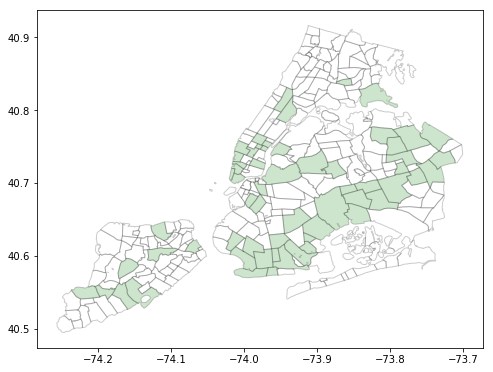

In [15]:
plotNeighborhoods(SPdrop)

['Astoria',
 'Eltingville',
 'St. Albans',
 'Annadale',
 'Gerritsen Beach',
 'Utopia',
 'East Jamaica Bay Islands',
 'Inwood',
 'Fresh Kills Park',
 'Elm Park',
 'Country Club',
 'Morningside Heights',
 'Eastchester',
 'Navy Yard',
 'Williamsbridge',
 'New Utrecht',
 'New Springville',
 'Bedford Park',
 'Malba',
 'Upper West Side',
 'Castle Hill',
 'Silver Lake',
 'Clinton Hill',
 'Bergen Beach',
 'Concourse',
 'Tribeca',
 'Todt Hill',
 'Turtle Bay',
 'Tudor City',
 'Stuyvesant Town',
 'Fort Tilden',
 'South Beach',
 'Flatiron District',
 'Westchester Heights',
 'Clason Point',
 'Randals-Wards Island',
 'Battery Park',
 'Corona',
 'Fort Wadsworth',
 'Stapleton',
 'Midtown',
 'Marine Park',
 'Marble Hill',
 'Jamaica',
 'Elmhurst',
 'Willowbrook',
 'Mill Basin',
 'West Village',
 'Sunset Park',
 'Vinegar Hill',
 'John F. Kennedy International Airport',
 'Van Nest',
 'Rego Park',
 'Harlem',
 'Wingate',
 'Murray Hill',
 'Butler Manor',
 'Bensonhurst',
 'Homecrest',
 'Middle Village',
 'Bli

In [ ]:
#countNull(NYsalespriceID)

In [ ]:
featureOneFinal = SPdrop
#saveCSV(SPdrop,'Cleaned_MedianListingPricePerSqft_AllHomes')

### Feature 2 

In [ ]:
rentalprice=pd.read_csv(featureTwo)
#rentalprice.head()

In [ ]:
NYrentalprice = filterThis(rentalprice, 'City','New York')

print(NYrentalprice.shape)

NYrentalprice = lastFewYears(NYrentalprice, 6,theseYears)

NYrentalprice.head()


In [ ]:
#add region ID
NYrentalpriceID = makeRegID(NYrentalprice)
#NYrentalpriceID = NYrentalprice

In [ ]:
#completeRP = NYrentalpriceID.dropna()

RPdrop = dropThese(NYrentalpriceID, DthreshVar)

print('There are %d usable neighborhoods.' %RPdrop.shape[0])

In [ ]:

RPdrop.RegionID = RPdrop.RegionID.astype(str)


plotNeighborhoods(RPdrop)

In [ ]:
#countNull(NYrentalpriceID)

In [ ]:
featureTwoFinal = RPdrop

### Feature 3 - Percent Decreasing

In [ ]:
percentDec=pd.read_csv(featureThree)  
#percentDec.head()
#percentDec.shape

In [ ]:
NYpercentDec = filterThis(percentDec,'City', 'New York')
print(NYpercentDec.shape)

NYpercentDec = lastFewYears(NYpercentDec, 7, theseYears)

NYpercentDec

In [ ]:
#completePD = NYpercentDec.dropna()

PDdrop = dropThese(NYpercentDec, DthreshVar)

print('There are %d usable neighborhoods.' %PDdrop.shape[0])

In [ ]:


PDdrop.RegionID = PDdrop.RegionID.astype(str)

#print(type(completePD.RegionID.iloc[0]))
plotNeighborhoods(PDdrop)

In [ ]:
#countNull(NYpercentDec)

In [ ]:
featureThreeFinal = PDdrop
saveCSV(PDdrop,'Cleaned_PctOfHomesDecreasingInValues_AllHomes')

### Feature 4 - Percent Increasing

In [ ]:
percentInc=pd.read_csv(featureFour)
#percentInc.head()

In [ ]:
NYpercentInc = filterThis(percentInc,'City','New York')

NYpercentInc = lastFewYears(NYpercentInc, 7,theseYears)

NYpercentInc.head()

In [ ]:
NYpercentInc.shape

In [ ]:
#completePI = NYpercentInc.dropna()

PIdrop = dropThese(NYpercentInc, DthreshVar)

print('There are %d usable neighborhoods.' %PIdrop.shape[0])

In [ ]:

PIdrop.RegionID = PIdrop.RegionID.astype(str)

print('There are %d complete rows.' %PIdrop.shape[0])

plotNeighborhoods(PIdrop)

In [ ]:
featureFourFinal = PIdrop
saveCSV(PIdrop,'Cleaned_PctOfHomesIncreasingInValues_AllHomes')

### Feature 5 - Bottom Tier

In [ ]:
bottomtier=pd.read_csv(featureFive)

#foreclosures.head()

In [ ]:
#NYtoptier = filterThis(bottomtier,'StateName','New York')
#NYtoptier.shape

In [ ]:
bottomtier.RegionID = bottomtier.RegionID.astype(int)

#filter by regionID
NYbottomtier = bottomtier.loc[bottomtier.loc[:,'RegionID'].isin(NYregions.keys())]

NYbottomtier.head()

In [ ]:
#drop seasonal adjustment
NYbottomtier = NYbottomtier.drop('seasAdj',axis=1)

NYbottomtier = lastFewYears(NYbottomtier, 4,theseYears)

In [ ]:
NYbottomtier.head()

In [ ]:
NYbottomtier.shape

In [ ]:
#countNull(NYtoptier)
BTdrop = dropThese(NYbottomtier, DthreshVar)
#TTdrop.head()

#print(TTdrop[TTdrop.iloc[TTdrop.loc[721,4]]])

In [ ]:
#completeTT = NYtoptier.dropna()

BTdrop.RegionID = BTdrop.RegionID.astype(str)

print('There are %d usable neighborhoods in this data.' %BTdrop.shape[0])

plotNeighborhoods(BTdrop)

In [ ]:
featureFiveFinal = BTdrop
saveCSV(BTdrop,'Cleaned_Sale_Counts_BottomTier_Neighborhood')

### Feature 6 - Top Tier

In [ ]:
toptier=pd.read_csv(featureSix)
#toptier.head()

In [ ]:
#NYtoptier = filterThis(toptier,'StateName','New York')
#NYtoptier.shape

In [ ]:
toptier.RegionID = toptier.RegionID.astype(int)

#filter by regionID
NYtoptier = toptier.loc[toptier.loc[:,'RegionID'].isin(NYregions.keys())]

#NYtoptier.head()

In [ ]:
#drop seasonal adjustment
NYtoptier = NYtoptier.drop('seasAdj',axis=1)

NYtoptier = lastFewYears(NYtoptier, 4,theseYears)

In [ ]:
NYtoptier.head()

In [ ]:
NYtoptier.shape

In [ ]:
#countNull(NYtoptier)
TTdrop = dropThese(NYtoptier, DthreshVar)
#TTdrop.head()

#print(TTdrop[TTdrop.iloc[TTdrop.loc[721,4]]])

In [ ]:
#completeTT = NYtoptier.dropna()

TTdrop.RegionID = TTdrop.RegionID.astype(str)

print('There are %d usable neighborhoods in this data.' %TTdrop.shape[0])

plotNeighborhoods(TTdrop)

In [ ]:
featureSixFinal = TTdrop
saveCSV(TTdrop,'Cleaned_Sale_Counts_TopTier_Neighborhood')

### Feature 7 - Inventory

In [ ]:
inventory=pd.read_csv(featureSeven)

#inventory.head()
NYinventory = filterThis(inventory,'City','New York')

NYinventory = lastFewYears(NYinventory, 4,theseYears)

NYinventory = makeRegID(NYinventory)

print(NYinventory.shape)

NYinventory.head()

In [ ]:
#completeIn = NYinventory.dropna()

Indrop = dropThese(NYinventory, DthreshVar)

print('There are %d usable neighborhoods.' %Indrop.shape[0])

Indrop.head()

In [ ]:

plotNeighborhoods(Indrop)

In [ ]:
#plot.scatter(inDrop.iloc[0,5:])

In [ ]:
featureSevenFinal = Indrop

saveCSV(Indrop,'Cleaned_InventoryMeasure_Neighborhood_Public')

In [ ]:
featureSevenFinal.shape

In [ ]:
test=pd.read_csv('data/NYC_Cleaned_InventoryMeasure_Neighborhood_Public_12_9.csv')


test.shape

# Neighborhood Overlap

In [ ]:
featuresA = [ featureOneFinal,
            featureThreeFinal,
            featureFourFinal,
            featureFiveFinal,
            featureSixFinal,
            featureSevenFinal]


featuresB = [featureSixFinal, featureSevenFinal]

featuresC = [ featureOneFinal,
            featureThreeFinal,
            featureFourFinal,
            featureSevenFinal]

featuresD = [featureFourFinal,
            featureSevenFinal]

featuresE = [featureOneFinal,
             featureFourFinal,
            featureSevenFinal]

featuresF = [featureFiveFinal,
            featureSixFinal,featureFourFinal,featureThreeFinal]

In [ ]:

def overlappingNeighborhoods(features):
    overlapped = features[0].RegionID
    print('data lengths:\n%d' %(len(overlapped)))
    for f in range(1,(len(features))): 
        print('%d' %(len(features[f])))
        overlappedNew = overlapped
        for d in range(len(overlappedNew)):
            if overlappedNew.iloc[d] not in features[f].RegionID.unique():
                overlapped = overlapped.drop(overlappedNew.index[d])
    print('There are %d overlapping neighborhoods represented.' %len(overlapped))
    return overlapped


In [ ]:
plotNeighborhoods(overlappingNeighborhoods(featuresC).to_frame(name='RegionID'))

In [ ]:
finalIDs = overlappingNeighborhoods(featuresC).to_frame(name='RegionID')

In [ ]:
for f in range(finalIDs.shape[0]):
    print(NYregions[finalIDs.iloc[f,0]])


In [ ]:
def findNaN(df):
    print('there are %d rows with NaN.' %(df.shape[0]-df.dropna().shape[0]))
    for n in range(60):
        if df.isnull():
            print(n)

#findNaN(featureOneFinal)

In [ ]:
def normalizeIt(myList):
    nMin = myList.min()
    nMax = myList.max()
    for l in range(len(myList)):
        myList[l]=(myList[l] - nMin)/(nMax-nMin) #normalize activity of various cathegories within row by total
    
    #print(myList)
    stdDev = myList.std()
    return stdDev 

normalizeIt(featureSevenFinal.iloc[4,-60:])